In [1]:
# Nikhil Patil
# CSEC 620 Project 2
# K-Means Mahalanobis Implementation 
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import re, random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from scipy.optimize import linear_sum_assignment

WINE_DATA = pd.read_csv("./wine/wine.data") 
IRIS_DATA = pd.read_csv("./Iris/iris.data")

# K-means clustering algorithm
class KMeans_Mahalanobis:
    """
    A simple K-means clustering implementation with Mahalanobis distance metric.

    This class implements the K-means clustering algorithm with Mahalanobis distance metric. 
    The algorithm is used to partition a dataset into K clusters by iteratively assigning data points to 
    the nearest cluster centroid and updating the centroids based on the mean of the data points in each cluster.

    Attributes:
        k (int): The number of clusters to form.
        max_iters (int): The maximum number of iterations for the algorithm to converge. Default is 100.
        centroids (np.ndarray): The coordinates of the cluster centroids.
        clusters (np.ndarray): The cluster labels for each data point.
        C (int): The covariance matrix for the Mahalanobis distance metric.
    
    Methods:
        mahalanobis_distance: Calculate the Mahalanobis distance between two points.
        fit: Fit the K-means algorithm to the data.
        create_clusters: Assign data points to the nearest cluster centroid.
        calculate_centroids: Update the cluster centroids based on the mean of the data points in each cluster.
        predict: Predict the cluster labels for new data
    """
    def __init__(self, k=3, max_iters=100, C=3):
        self.k = k
        self.max_iters = max_iters
        self.centroids = None
        self.clusters = None
        self.C = C
        
    def mahalanobis_distance(self, point1, point2):
        diff = point1 - point2
        return np.sqrt(np.dot(np.dot(diff.T, self.C), diff))
    
    def fit(self, X):
    
        np.random.seed(random.randint(1,100))  # for reproducibility
        random_indices = np.random.permutation(X.shape[0])[:self.k]
        self.centroids = X[random_indices]
        
        for i in range(self.max_iters):
            self.clusters = self.create_clusters(X)
            old_centroids = self.centroids
            self.centroids = self.calculate_centroids(X)
            if np.all(old_centroids == self.centroids):
                break
    
    def create_clusters(self, X):
        clusters = [[] for _ in range(self.k)]
        for idx, point in enumerate(X):
            closest_centroid = np.argmin([self.mahalanobis_distance(point, centroid) for centroid in self.centroids])
            clusters[closest_centroid].append(idx)
        return clusters
    
    def calculate_centroids(self, X):
        centroids = np.zeros((self.k, X.shape[1]))
        for cluster_idx, cluster in enumerate(self.clusters):
            if cluster:  # Avoid empty clusters
                centroids[cluster_idx] = np.mean(X[cluster], axis=0)
        return centroids
    
    def predict(self, X):
        return np.array([np.argmin([self.mahalanobis_distance(x, centroid) for centroid in self.centroids]) for x in X])

In [2]:
def get_column_names():
    """
    Obtains column names for the respective datasets as the datasets come unlabeled
    
    It takes the filepath from the directory, creates a list for the columns as well as line counter. 
    Line counter counts the lines in the file until it reaches a certain threshold, where it then adds those lines to the list of columns. The lines will not change unless the .names files are modifiied.
    After adding the column names to a list, regular expressions are used to clean up the strings (remove numbers). 
    
    :return: two python lists consisting of columns
    """
    wine_names = "./wine/wine.names"
    iris_names = "./Iris/iris.names"
    wine_columns = []
    iris_columns = []
    
    wine_line_counter = 0
    iris_line_counter = 0
    class_identifier = ""
    with open(wine_names) as f:
        for line in f:
            wine_line_counter += 1
            if(wine_line_counter > 57 and wine_line_counter <= 70):
                line = line.strip()
                wine_columns.append(line)
            if wine_line_counter == 75:
                line = line.strip()
                class_identifier = re.search(r'\bclass\b', line)
    f.close()
    wine_columns =  [re.sub(r'^\d+\)\s*', '', column) for column in wine_columns]
    wine_columns.insert(0, class_identifier.group())
    with open(iris_names) as f:
        for line in f:
            iris_line_counter += 1
            if(iris_line_counter > 50 and iris_line_counter < 56):
                line = line.strip()
                iris_columns.append(line)
    f.close()
    iris_columns =  [re.sub(r'^\d+\.\s*', '', column) for column in iris_columns]
    
    print(wine_columns)
    print(iris_columns)
    
    return wine_columns, iris_columns

In [3]:
def wine_classification(wine_columns):
    """
    This function aims to classify different types of Wines via a dataset and using K-means Mahalanobis clustering. It also processes the dataframe prior to use and uses seaborn to plot the dataset as well as to create a heatmap.     
    :param wine_columns: The column headers of the Wine dataset
    """
    
    df = WINE_DATA
    df.columns = wine_columns

    # Replace the class labels with the corresponding strings
    class_mapping = {1: 'Wine 1', 2: 'Wine 2', 3: 'Wine 3'}

    df['class'] = df['class'].replace(class_mapping)
    actual_labels = df['class'].values
    label_mapping = {'Wine 1': 0, 'Wine 2': 1, 'Wine 3': 2}
    actual_labels = [label_mapping[label] for label in actual_labels]
    df.drop("class", axis=1, inplace=True)
    
    scaler = StandardScaler()
    transformed_features = scaler.fit_transform(df)
    
    scaled_df = pd.DataFrame(transformed_features, columns=df.columns)
    
    kmeans = KMeans_Mahalanobis(k=3) # three clusters since 3 different types of wine 
    kmeans.fit(scaled_df.values)  # Fit the model on the scaled features
    
    # Get the predicted cluster labels
    clusters = kmeans.predict(scaled_df.values)
    
    # Add the cluster labels to the DataFrame for analysis
    scaled_df['Cluster'] = clusters
    
    # Perform PCA to reduce to 2 components for visualization
    pca = PCA(n_components=2)
    
    # Apply PCA only on the numerical features (exclude 'Cluster' column)
    pca_result = pca.fit_transform(scaled_df.drop('Cluster', axis=1))

    # Create a new DataFrame for the PCA results and the cluster labels
    pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
    pca_df['Cluster'] = clusters

    # Plot the PCA results with clusters
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='viridis', s=100, alpha=0.8)
    plt.title('Wine Clusters Visualized using PCA')
    plt.show()

    component_df=pd.DataFrame(pca.components_,index=['PCA1',"PCA2"],columns=df.columns)
    # Heat map
    sns.heatmap(component_df)
    plt.show() 

    # create confusion matrix and classification report
    conf_matrix = confusion_matrix(actual_labels, clusters)
    
    row_ind, col_ind = linear_sum_assignment(-conf_matrix)
    cluster_to_class_mapping = {row: col for row, col in zip(row_ind, col_ind)}
    predicted_labels = [cluster_to_class_mapping[cluster] for cluster in clusters]
    
    # Generate and print the classification report
    target_names = ["Wine 1", "Wine 2", "Wine 3"]
    print(classification_report(actual_labels, predicted_labels, target_names=target_names, zero_division=1))
    
    # Visualize the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues',
                xticklabels=["Cluster 0", 'Cluster 1', "Cluster 2"], yticklabels=target_names)
    
    plt.xlabel("Predicted Clusters")
    plt.ylabel("Actual Classes")
    plt.title("Confusion Matrix for K-means Mahalanobis on Wine Dataset")
    plt.show()

In [4]:
def iris_classification(iris_columns):
    """
    This function aims to classify different types of Iris' flowers via a dataset and using K-means clustering. It also processes the dataframe prior to use and uses seaborn to plot the dataset as well as to create a heatmap. 
    :param iris_columns: a list of column headers
    """
    # load and preprocess data
    df = IRIS_DATA
    df.columns = iris_columns
    actual_labels = df['class:'].values
    label_mapping = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
    actual_labels = [label_mapping[label] for label in actual_labels]
    df.drop("class:",axis=1,inplace=True)
    
    scaler = StandardScaler()
    transformed_features = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(transformed_features, columns=df.columns)
    
    kmeans = KMeans_Mahalanobis(k=3) # three clusters since 3 different types of wine 
    kmeans.fit(scaled_df.values)  # Fit the model on the scaled features
    
    # Get the predicted cluster labels
    clusters = kmeans.predict(scaled_df.values)
    # Add the cluster labels to the DataFrame for analysis
    scaled_df['Cluster'] = clusters
    # print(scaled_df.head())

    # Perform PCA to reduce to 2 components for visualization
    pca = PCA(n_components=2)
    
    # Apply PCA only on the numerical features (exclude 'Cluster' column)
    pca_result = pca.fit_transform(scaled_df.drop('Cluster', axis=1))

    # Create a new DataFrame for the PCA results and the cluster labels
    pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
    pca_df['Cluster'] = clusters

    # Plot the PCA results with clusters
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='viridis', s=100, alpha=0.8)
    plt.title('Different Types of Iris Flowers Visualized using PCA')
    plt.show()
    
    component_df=pd.DataFrame(pca.components_,index=['PCA1',"PCA2"],columns=df.columns)
    # Heat map
    sns.heatmap(component_df)
    plt.show()
    
    # create confusion matrix and classification report
    conf_matrix = confusion_matrix(actual_labels, clusters)
    
    row_ind, col_ind = linear_sum_assignment(-conf_matrix)
    cluster_to_class_mapping = {row: col for row, col in zip(row_ind, col_ind)}
    predicted_labels = [cluster_to_class_mapping[cluster] for cluster in clusters]
    
    print(classification_report(actual_labels, predicted_labels, target_names=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']))

# Visualize the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues',
            xticklabels=['Cluster 0', 'Cluster 1', 'Cluster 2'],
            yticklabels=['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])
    
    plt.xlabel("Predicted Clusters")
    plt.ylabel("Actual Classes")
    plt.title("Confusion Matrix for K-means Mahalanobis on Iris Dataset")
    plt.show()

['class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
['sepal length in cm', 'sepal width in cm', 'petal length in cm', 'petal width in cm', 'class:']


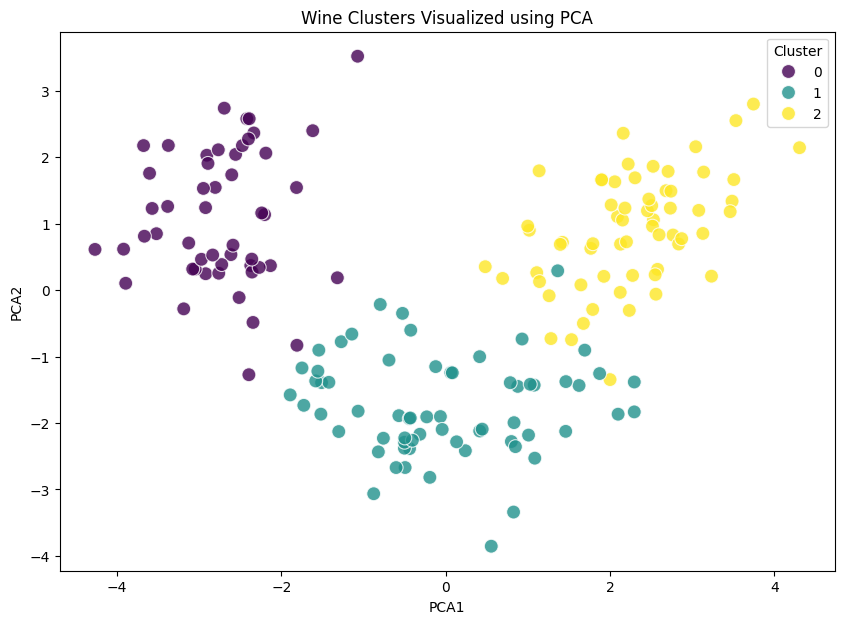

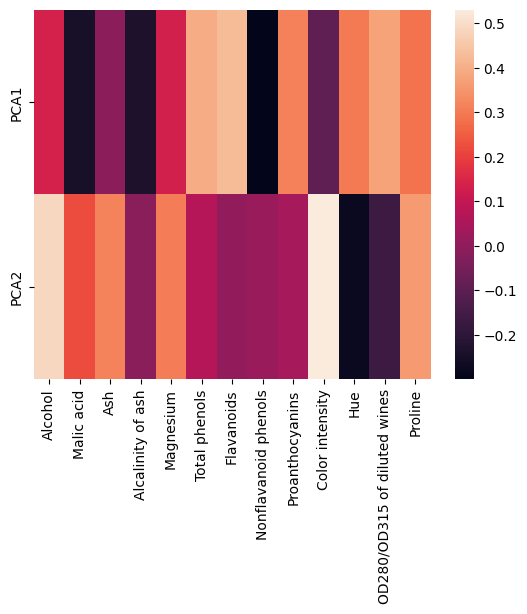

              precision    recall  f1-score   support

      Wine 1       0.94      1.00      0.97        58
      Wine 2       1.00      0.90      0.95        71
      Wine 3       0.94      1.00      0.97        48

    accuracy                           0.96       177
   macro avg       0.96      0.97      0.96       177
weighted avg       0.96      0.96      0.96       177



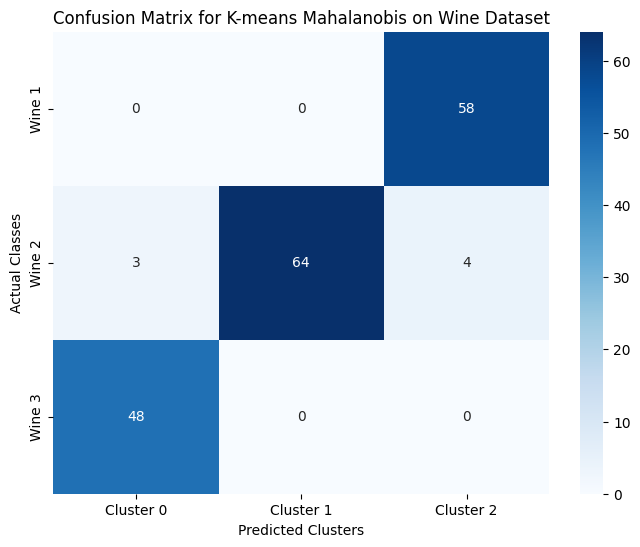

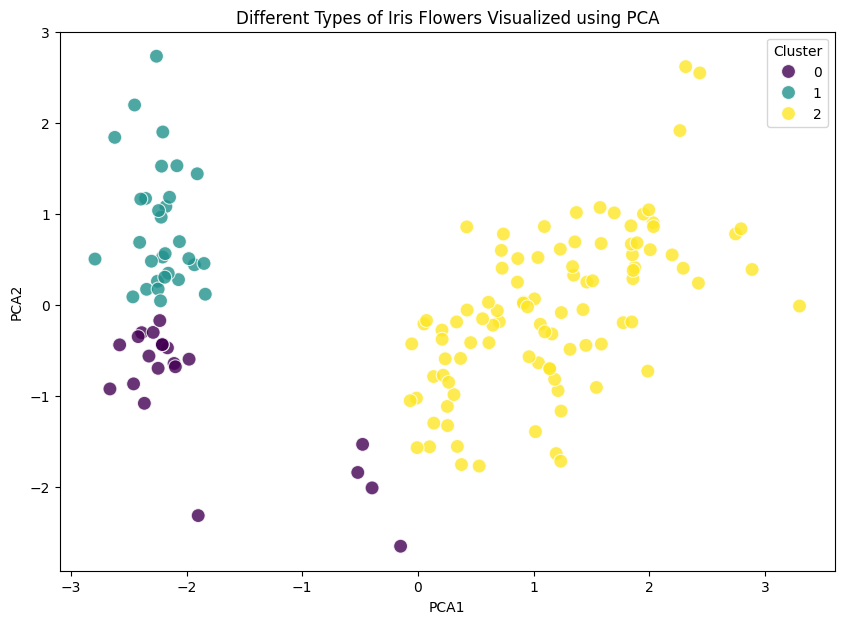

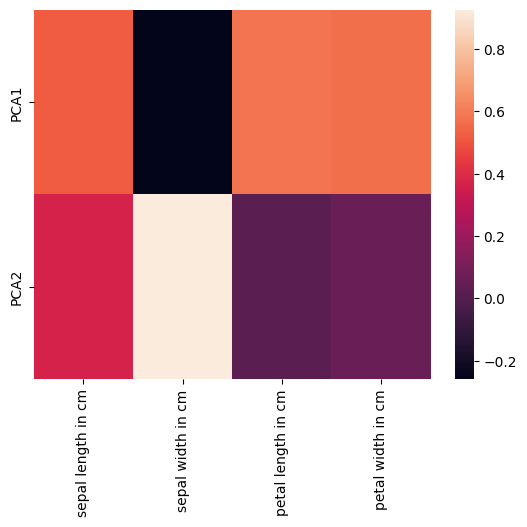

                 precision    recall  f1-score   support

    Iris-setosa       1.00      0.63      0.78        49
Iris-versicolor       0.18      0.08      0.11        50
 Iris-virginica       0.52      1.00      0.68        50

       accuracy                           0.57       149
      macro avg       0.57      0.57      0.52       149
   weighted avg       0.56      0.57      0.52       149



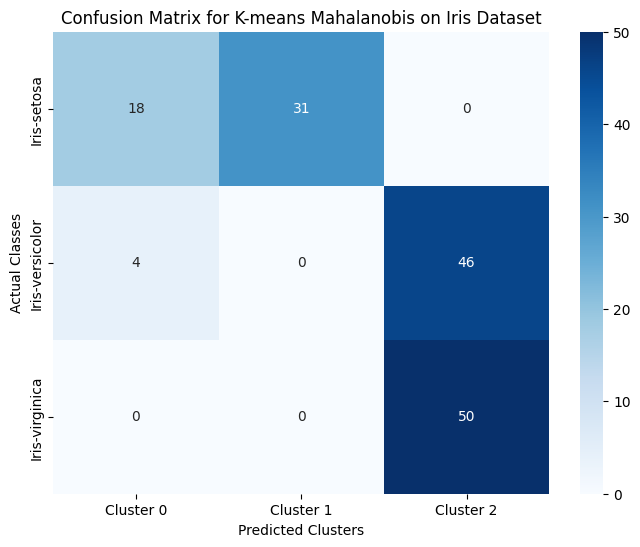

In [5]:
def main():
    wine_columns, iris_columns = get_column_names()
    wine_classification(wine_columns)
    iris_classification(iris_columns)

    
if __name__ == "__main__":
    main()